In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from bs4 import BeautifulSoup
import scipy.stats as stats
import seaborn as sns

In [28]:
aus_daily_ranks=pd.read_csv('/Users/khanhnguyen/UNI/S2_2023/Grand Challenges/Project 1 refined/australia_data_final.csv')
aus_daily_ranks['popularity'] = pd.to_numeric(aus_daily_ranks['popularity'], errors='coerce')
aus_daily_ranks['valence'] = pd.to_numeric(aus_daily_ranks['valence'], errors='coerce')
aus_daily_ranks['date'] = pd.to_datetime(aus_daily_ranks['date'])
condition_d = 0.64
condition_e = 0.60
condition_v = 0.56
numeric_columns = ['danceability', 'energy', 'valence']
aus_daily_ranks[numeric_columns] = aus_daily_ranks[numeric_columns].apply(pd.to_numeric, errors='coerce')
start_date = pd.Timestamp('2019-12-23')
end_date = pd.Timestamp('2020-1-1')
mask = (
    (aus_daily_ranks['date'] >= start_date) & (aus_daily_ranks['date'] <= end_date) &
    (aus_daily_ranks['danceability'] > condition_d) & (aus_daily_ranks['energy'] > condition_e) & (aus_daily_ranks['valence'] > condition_v)
)
filtered_dataset = aus_daily_ranks[~mask]
filtered_dataset['adjusted_valence_position'] = filtered_dataset['valence'] * (201 - filtered_dataset['position'])
filtered_dataset['adjusted_sadness_norm2_popularity'] = filtered_dataset['sadness_norm2'] * filtered_dataset['popularity']
min_val = filtered_dataset['adjusted_sadness_norm2_popularity'].min()
max_val = filtered_dataset['adjusted_sadness_norm2_popularity'].max()
filtered_dataset['scaled_adjusted_sadness_norm2'] = (filtered_dataset['adjusted_sadness_norm2_popularity'] - min_val) / (max_val - min_val)
filtered_dataset = filtered_dataset.fillna(0)
filtered_dataset.tail()

,position,date,log_ratio,adjusted_valence_popularity,scaled_adjusted_valence,valence,danceability,energy,sadness_norm2,popularity,stringency_index,new_cases_per_million,new_deaths_per_million,icu_patients_per_million,new_cases,adjusted_valence_position,adjusted_sadness_norm2_popularity,scaled_adjusted_sadness_norm2
59064,54.0,2020-01-03,0.180224,-17.808,0.908872,0.336,0.746,0.450,0.178571,6849.75,0.0,0.0,0.0,0.0,0.0,49.392,1223.169646,0.021477
59065,127.0,2020-01-03,-0.298976,-85.428,0.562845,0.678,0.806,0.558,0.000000,4013.30,0.0,0.0,0.0,0.0,0.0,50.172,0.000000,0.000000
59066,158.0,2020-01-03,-0.284624,-83.838,0.570981,0.534,0.599,0.733,0.375000,1412.80,0.0,0.0,0.0,0.0,0.0,22.962,529.800000,0.009302
59067,189.0,2020-01-03,-0.173215,-70.688,0.638273,0.376,0.802,0.645,0.000000,16629.05,0.0,0.0,0.0,0.0,0.0,4.512,0.000000,0.000000
59068,165.0,2020-01-03,0.082919,-34.276,0.824602,0.209,0.689,0.516,0.000000,4293.60,0.0,0.0,0.0,0.0,0.0,7.524,0.000000,0.000000


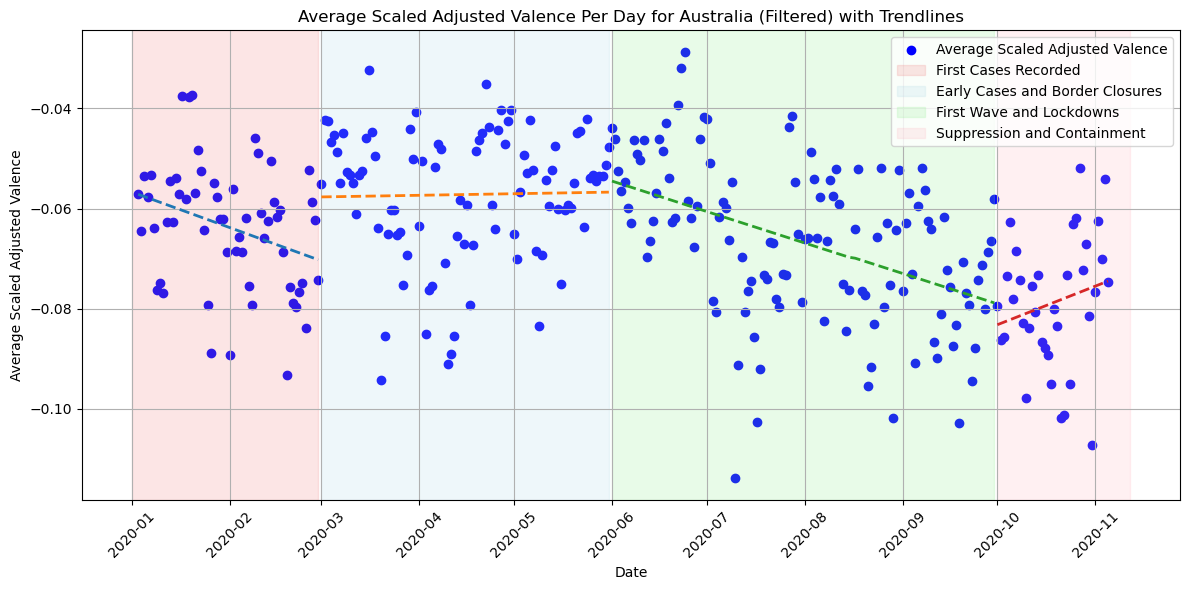

In [31]:
stages = [
    ('2020-01-01', '2020-02-29', 'First Cases Recorded', 'lightcoral'),
    ('2020-03-01', '2020-05-31', 'Early Cases and Border Closures', 'lightblue'),
    ('2020-06-01', '2020-09-30', 'First Wave and Lockdowns', 'lightgreen'),
    ('2020-10-01', '2020-11-12', 'Suppression and Containment', 'lightpink'),
]
avg_scaled_adjusted_valence = filtered_dataset.groupby('date')['log_ratio'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.scatter(avg_scaled_adjusted_valence['date'], avg_scaled_adjusted_valence['log_ratio'], color='blue', label='Average Scaled Adjusted Valence')
for start_date, end_date, stage_label, color in stages:
    plt.axvspan(start_date, end_date, alpha=0.2, color=color, label=stage_label)
def linear_fit(x, a, b):
    return a * x + b
for start_date, end_date, _, _ in stages:
    stage_data = avg_scaled_adjusted_valence[(avg_scaled_adjusted_valence['date'] >= start_date) & (avg_scaled_adjusted_valence['date'] <= end_date)]
    x = np.arange(len(stage_data))
    params, _ = curve_fit(linear_fit, x, stage_data['log_ratio'])
    a, b = params
    trendline = a * x + b
    plt.plot(stage_data['date'], trendline, linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Average Scaled Adjusted Valence')
plt.title('Average Scaled Adjusted Valence Per Day for Australia (Filtered) with Trendlines')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


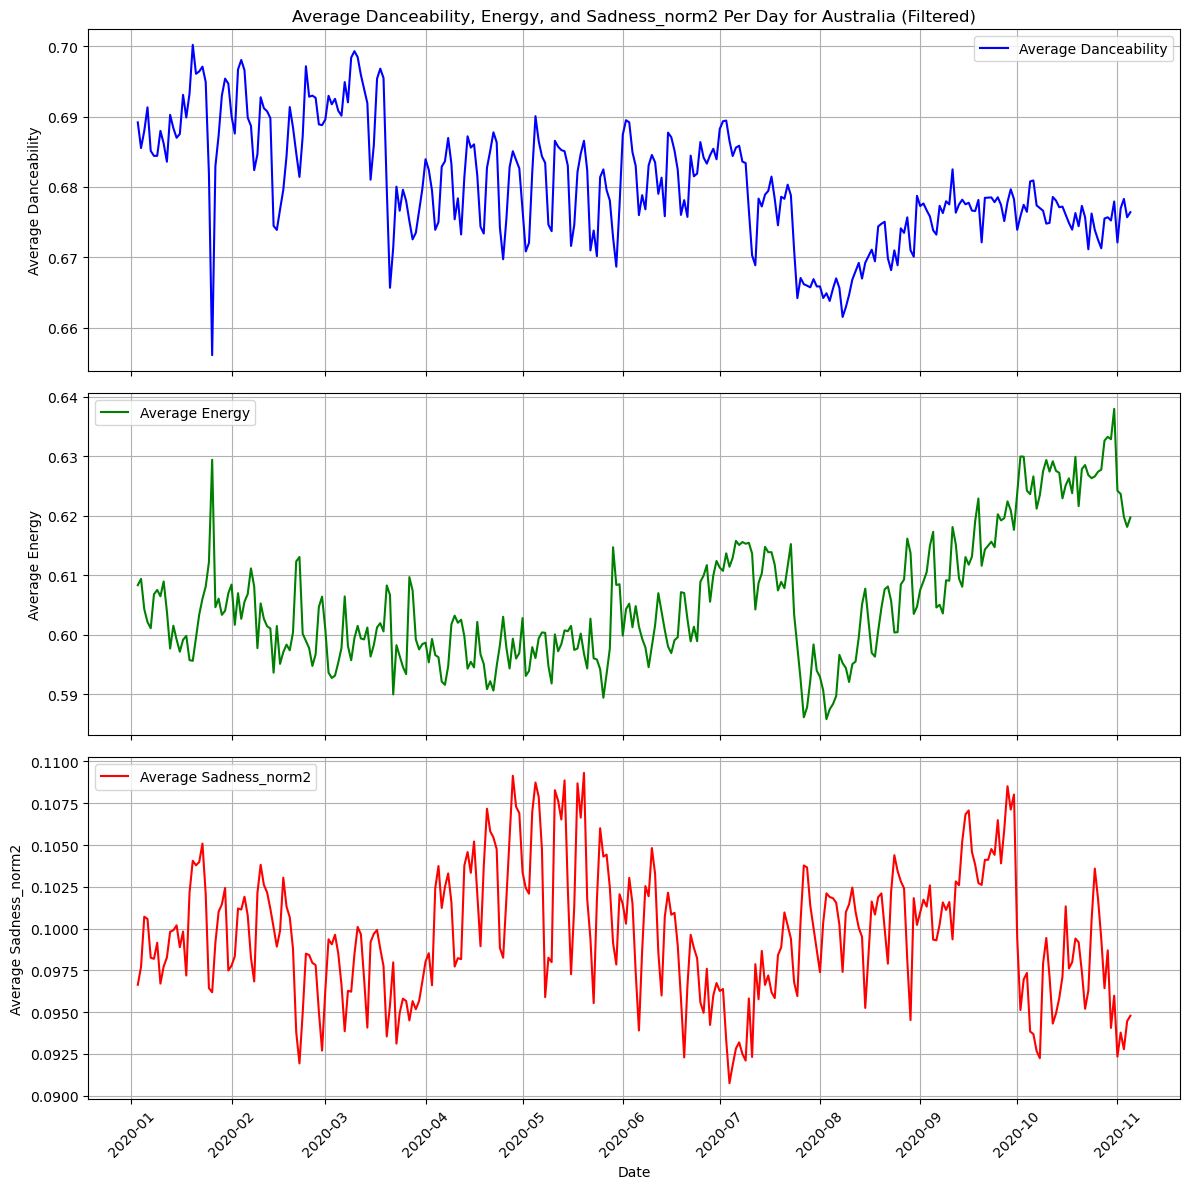

In [32]:
avg_metrics = filtered_dataset.groupby('date')[['danceability', 'energy', 'sadness_norm2']].mean().reset_index()
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
axs[0].plot(avg_metrics['date'], avg_metrics['danceability'], color='blue', label='Average Danceability')
axs[0].set_ylabel('Average Danceability')
axs[0].set_title('Average Danceability, Energy, and Sadness_norm2 Per Day for Australia (Filtered)')
axs[0].grid(True)
axs[0].legend()
axs[1].plot(avg_metrics['date'], avg_metrics['energy'], color='green', label='Average Energy')
axs[1].set_ylabel('Average Energy')
axs[1].grid(True)
axs[1].legend()
axs[2].plot(avg_metrics['date'], avg_metrics['sadness_norm2'], color='red', label='Average Sadness_norm2')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Average Sadness_norm2')
axs[2].grid(True)
axs[2].legend()

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()


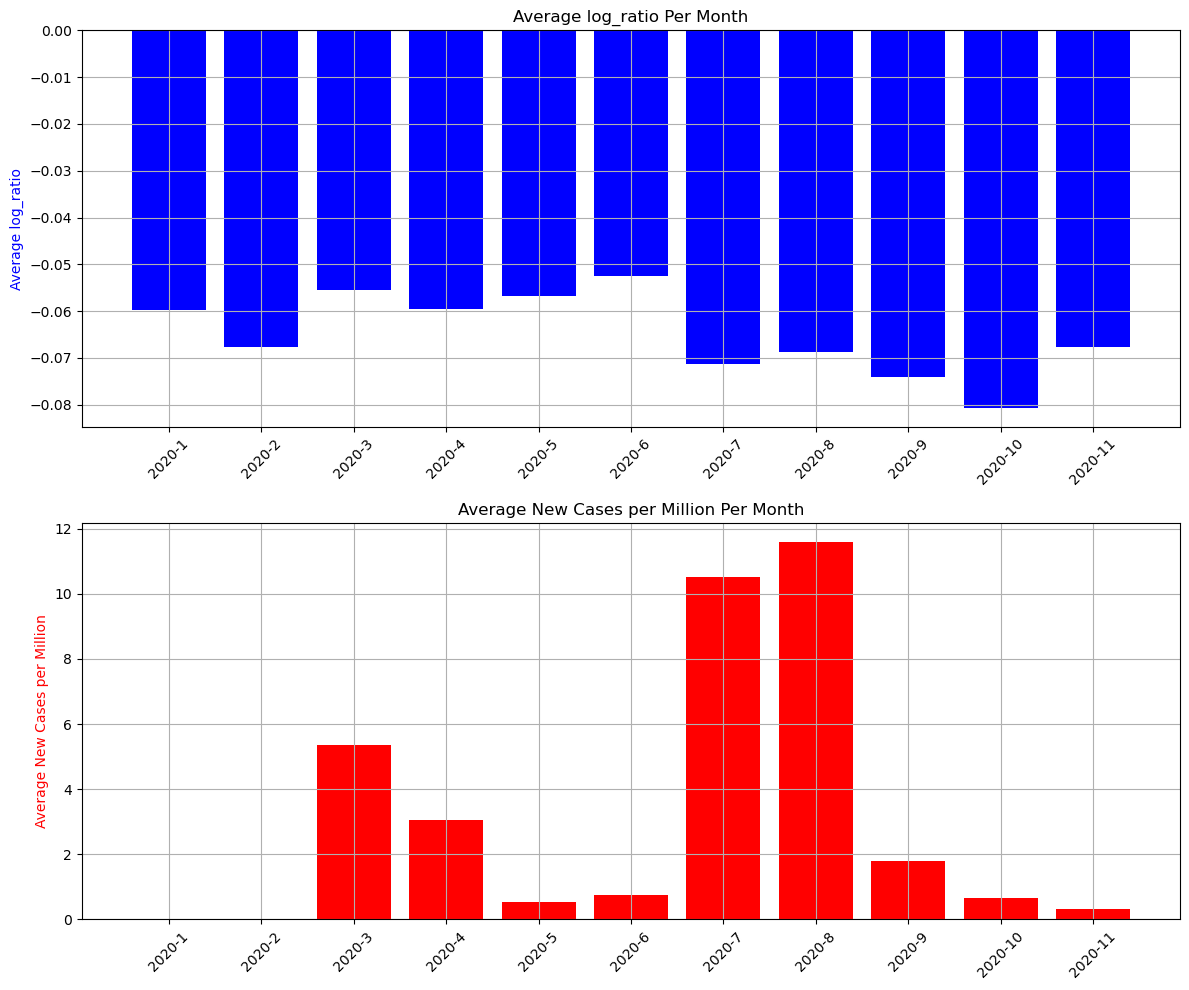

In [33]:
filtered_dataset['year'] = filtered_dataset['date'].dt.year
filtered_dataset['month'] = filtered_dataset['date'].dt.month

avg_log_ratio = filtered_dataset.groupby(['year', 'month'])['log_ratio'].mean().reset_index()
avg_new_cases = filtered_dataset.groupby(['year', 'month'])['new_cases_per_million'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.bar(avg_log_ratio['year'].astype(str) + '-' + avg_log_ratio['month'].astype(str), avg_log_ratio['log_ratio'], color='blue')
ax1.set_ylabel('Average log_ratio', color='blue')
ax1.set_title('Average log_ratio Per Month')
ax1.grid(True)

ax2.bar(avg_new_cases['year'].astype(str) + '-' + avg_new_cases['month'].astype(str), avg_new_cases['new_cases_per_million'], color='red')
ax2.set_ylabel('Average New Cases per Million', color='red')
ax2.set_title('Average New Cases per Million Per Month')
ax2.grid(True)

ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()


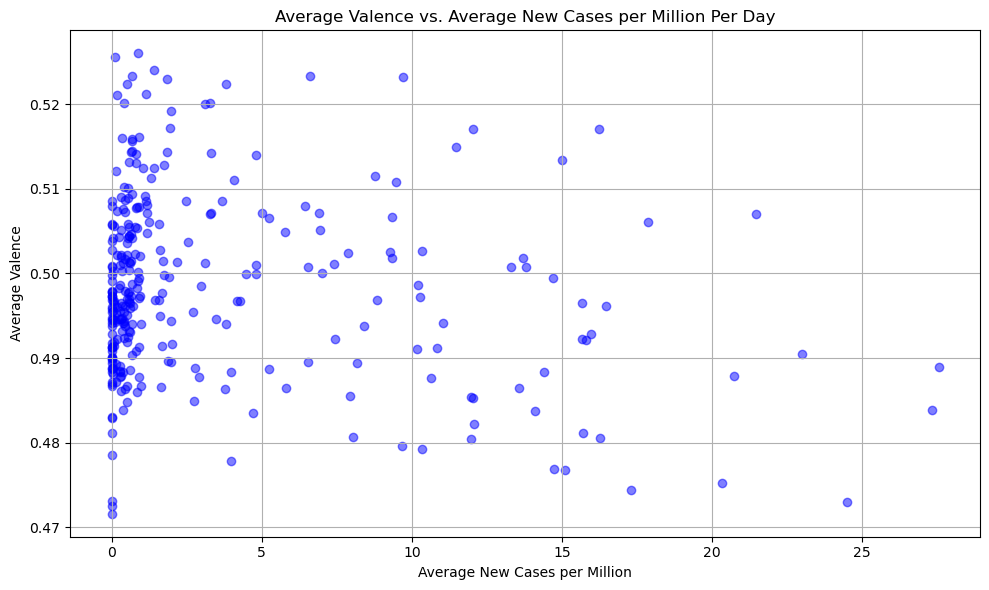

In [34]:
avg_valence = filtered_dataset.groupby('date')['valence'].mean().reset_index()
avg_new_cases = filtered_dataset.groupby('date')['new_cases_per_million'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(avg_new_cases['new_cases_per_million'], avg_valence['valence'], alpha=0.5, color='blue')
plt.title('Average Valence vs. Average New Cases per Million Per Day')
plt.xlabel('Average New Cases per Million')
plt.ylabel('Average Valence')
plt.grid(True)
plt.tight_layout()

plt.show()


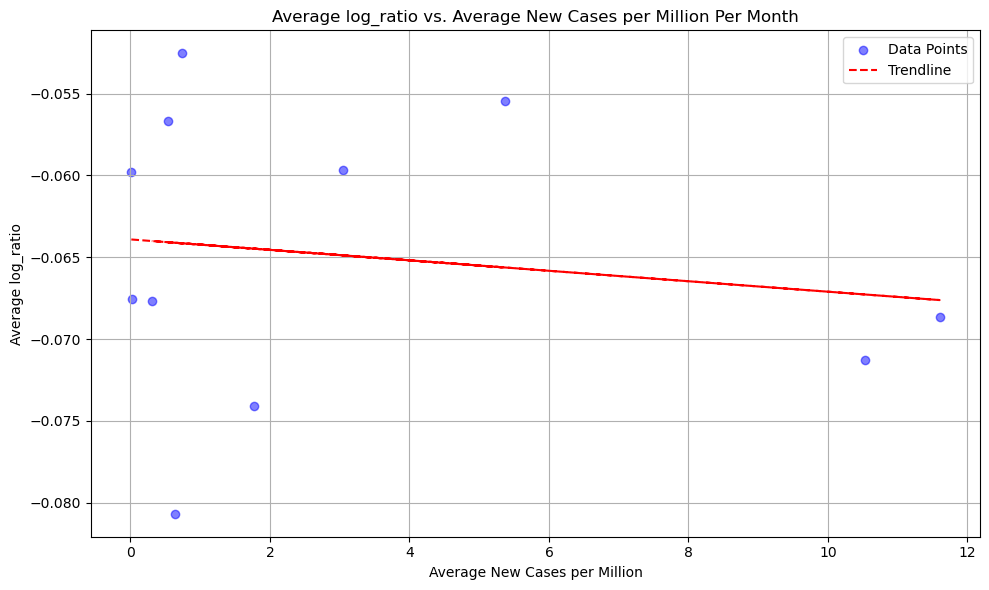

In [35]:
filtered_dataset['year'] = filtered_dataset['date'].dt.year
filtered_dataset['month'] = filtered_dataset['date'].dt.month
avg_log_ratio = filtered_dataset.groupby(['year', 'month'])['log_ratio'].mean().reset_index()
avg_new_cases = filtered_dataset.groupby(['year', 'month'])['new_cases_per_million'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(avg_new_cases['new_cases_per_million'], avg_log_ratio['log_ratio'], alpha=0.5, color='blue', label='Data Points')
z = np.polyfit(avg_new_cases['new_cases_per_million'], avg_log_ratio['log_ratio'], 1)
p = np.poly1d(z)
plt.plot(avg_new_cases['new_cases_per_million'], p(avg_new_cases['new_cases_per_million']), "r--", label='Trendline')

plt.title('Average log_ratio vs. Average New Cases per Million Per Month')
plt.xlabel('Average New Cases per Million')
plt.ylabel('Average log_ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


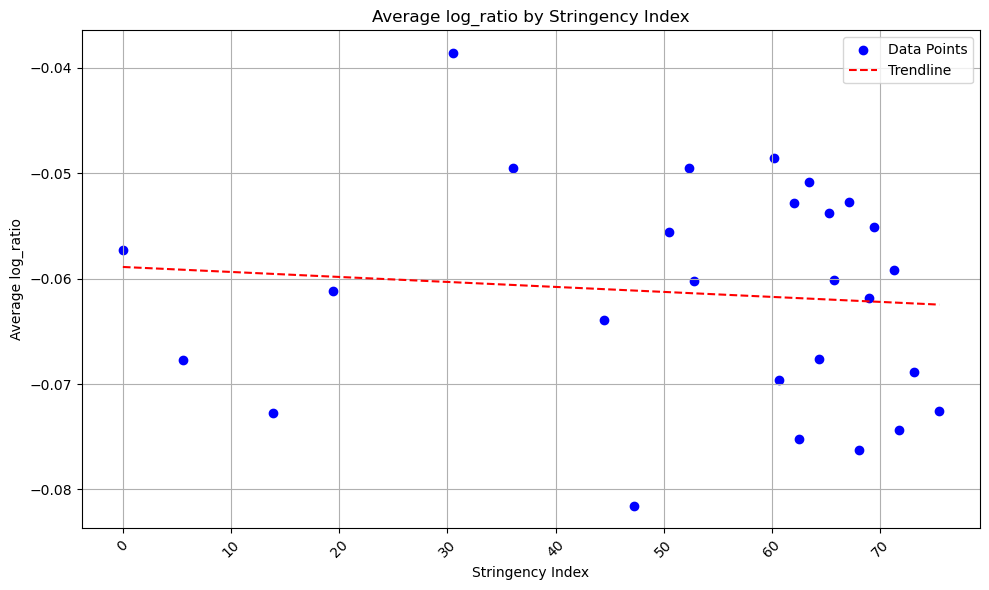

In [36]:
avg_log_ratio_by_stringency = filtered_dataset.groupby('stringency_index')['log_ratio'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(avg_log_ratio_by_stringency['stringency_index'], avg_log_ratio_by_stringency['log_ratio'], color='blue', label='Data Points')
z = np.polyfit(avg_log_ratio_by_stringency['stringency_index'], avg_log_ratio_by_stringency['log_ratio'], 1)
p = np.poly1d(z)
plt.plot(avg_log_ratio_by_stringency['stringency_index'], p(avg_log_ratio_by_stringency['stringency_index']), "r--", label='Trendline')

plt.title('Average log_ratio by Stringency Index')
plt.xlabel('Stringency Index')
plt.ylabel('Average log_ratio')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


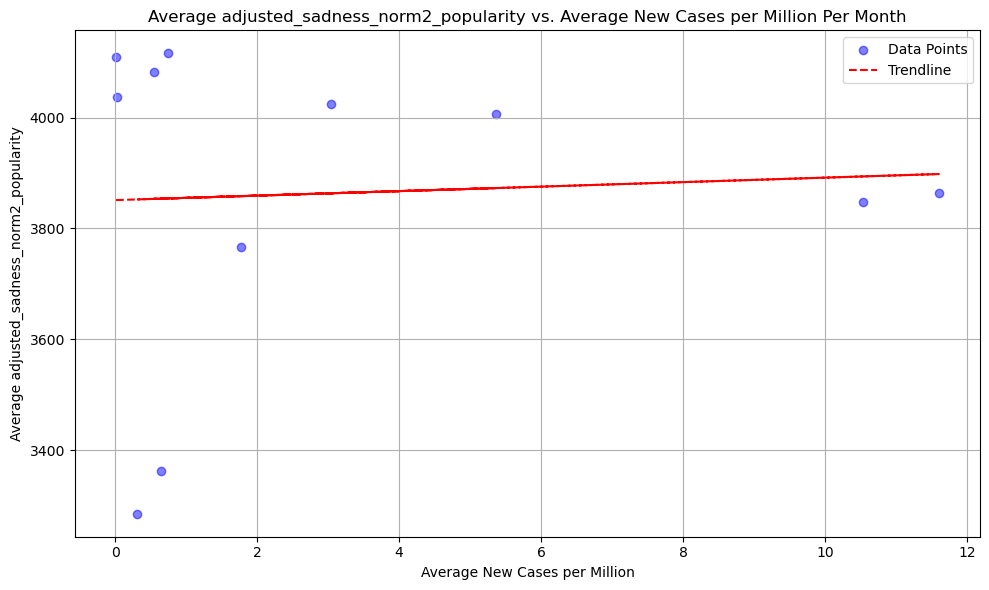

In [133]:
filtered_dataset['date'] = pd.to_datetime(filtered_dataset['date'])
filtered_dataset['year'] = filtered_dataset['date'].dt.year
filtered_dataset['month'] = filtered_dataset['date'].dt.month
avg_adjusted_sadness_norm2_popularity = filtered_dataset.groupby(['year', 'month'])['adjusted_sadness_norm2_popularity'].mean().reset_index()
avg_new_cases = filtered_dataset.groupby(['year', 'month'])['new_cases_per_million'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(avg_new_cases['new_cases_per_million'], avg_adjusted_sadness_norm2_popularity['adjusted_sadness_norm2_popularity'], alpha=0.5, color='blue', label='Data Points')
z = np.polyfit(avg_new_cases['new_cases_per_million'], avg_adjusted_sadness_norm2_popularity['adjusted_sadness_norm2_popularity'], 1)
p = np.poly1d(z)
plt.plot(avg_new_cases['new_cases_per_million'], p(avg_new_cases['new_cases_per_million']), "r--", label='Trendline')

plt.title('Average adjusted_sadness_norm2_popularity vs. Average New Cases per Million Per Month')
plt.xlabel('Average New Cases per Million')
plt.ylabel('Average adjusted_sadness_norm2_popularity')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


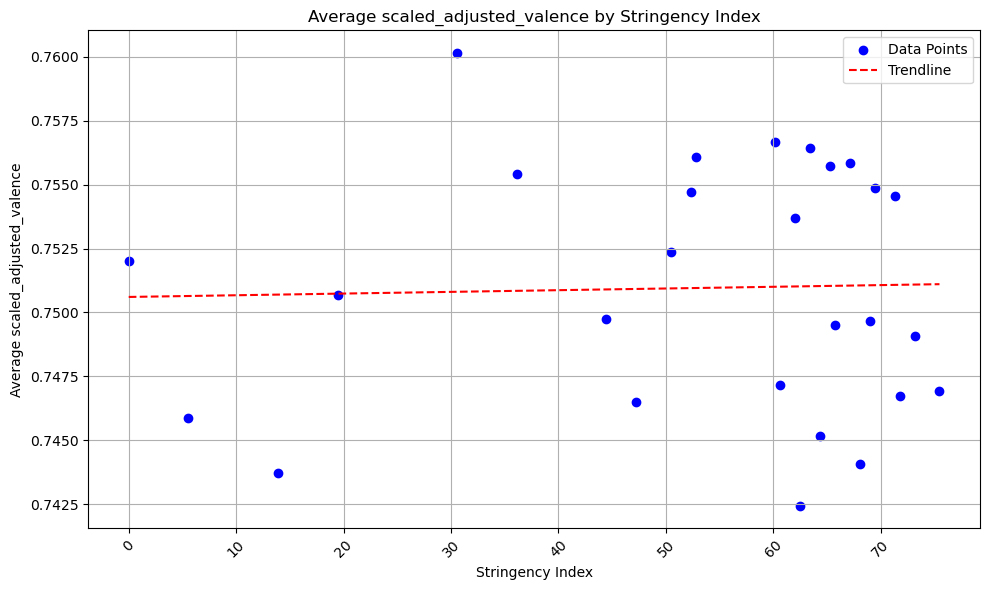

In [134]:
avg_scaled_adjusted_valence_by_stringency = filtered_dataset.groupby('stringency_index')['scaled_adjusted_valence'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(avg_scaled_adjusted_valence_by_stringency['stringency_index'], avg_scaled_adjusted_valence_by_stringency['scaled_adjusted_valence'], color='blue', label='Data Points')

z = np.polyfit(avg_scaled_adjusted_valence_by_stringency['stringency_index'], avg_scaled_adjusted_valence_by_stringency['scaled_adjusted_valence'], 1)
p = np.poly1d(z)
plt.plot(avg_scaled_adjusted_valence_by_stringency['stringency_index'], p(avg_scaled_adjusted_valence_by_stringency['stringency_index']), "r--", label='Trendline')

plt.title('Average scaled_adjusted_valence by Stringency Index')
plt.xlabel('Stringency Index')
plt.ylabel('Average scaled_adjusted_valence')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


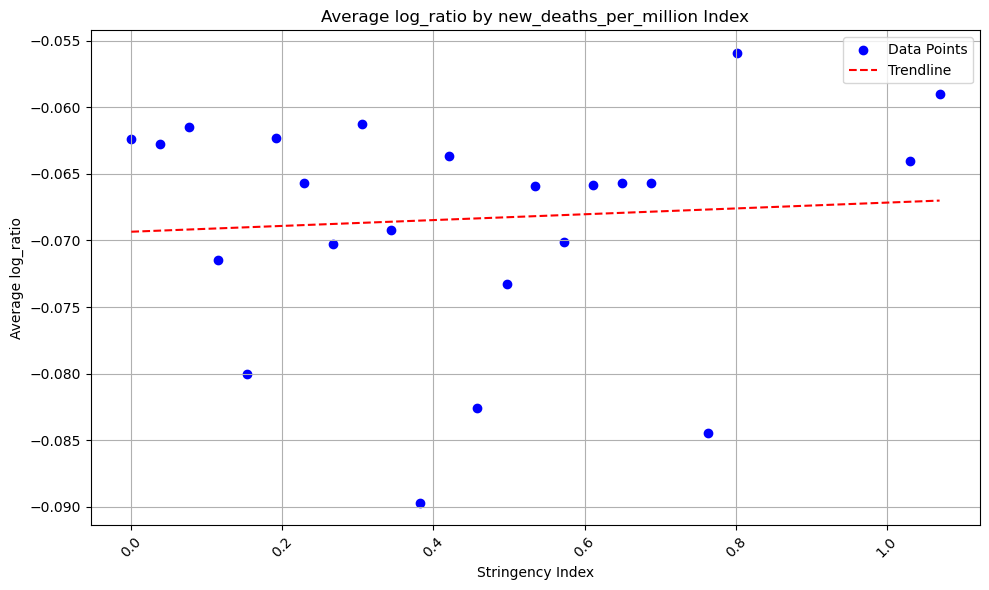

In [135]:
avg_log_ratio_by_stringency = filtered_dataset.groupby('new_deaths_per_million')['log_ratio'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(avg_log_ratio_by_stringency['new_deaths_per_million'], avg_log_ratio_by_stringency['log_ratio'], color='blue', label='Data Points')

z = np.polyfit(avg_log_ratio_by_stringency['new_deaths_per_million'], avg_log_ratio_by_stringency['log_ratio'], 1)
p = np.poly1d(z)
plt.plot(avg_log_ratio_by_stringency['new_deaths_per_million'], p(avg_log_ratio_by_stringency['new_deaths_per_million']), "r--", label='Trendline')

plt.title('Average log_ratio by new_deaths_per_million Index')
plt.xlabel('Stringency Index')
plt.ylabel('Average log_ratio')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


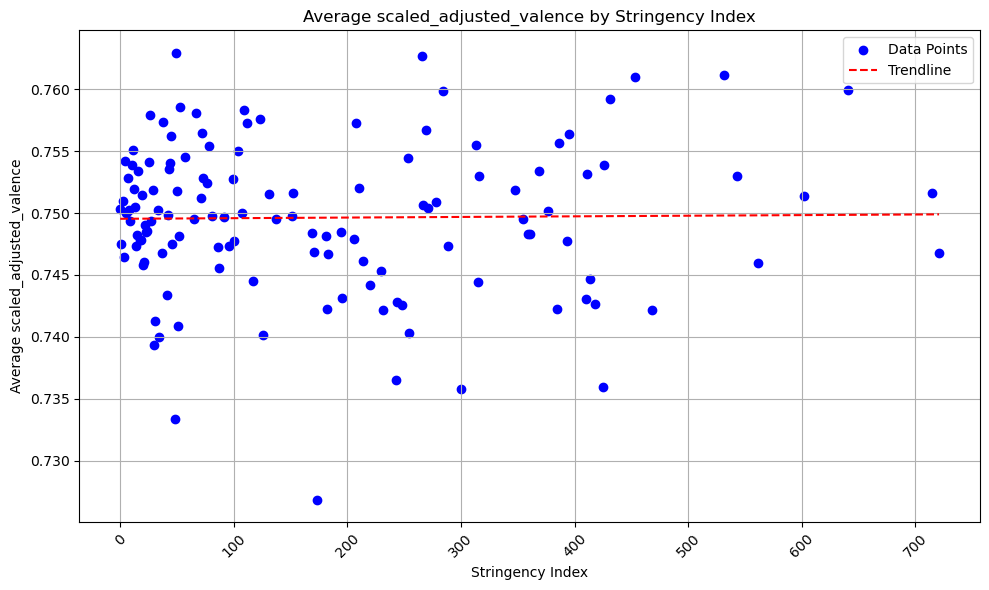

In [136]:
avg_scaled_adjusted_valence_by_stringency = filtered_dataset.groupby('new_cases')['scaled_adjusted_valence'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(avg_scaled_adjusted_valence_by_stringency['new_cases'], avg_scaled_adjusted_valence_by_stringency['scaled_adjusted_valence'], color='blue', label='Data Points')

z = np.polyfit(avg_scaled_adjusted_valence_by_stringency['new_cases'], avg_scaled_adjusted_valence_by_stringency['scaled_adjusted_valence'], 1)
p = np.poly1d(z)
plt.plot(avg_scaled_adjusted_valence_by_stringency['new_cases'], p(avg_scaled_adjusted_valence_by_stringency['new_cases']), "r--", label='Trendline')

plt.title('Average scaled_adjusted_valence by Stringency Index')
plt.xlabel('Stringency Index')
plt.ylabel('Average scaled_adjusted_valence')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


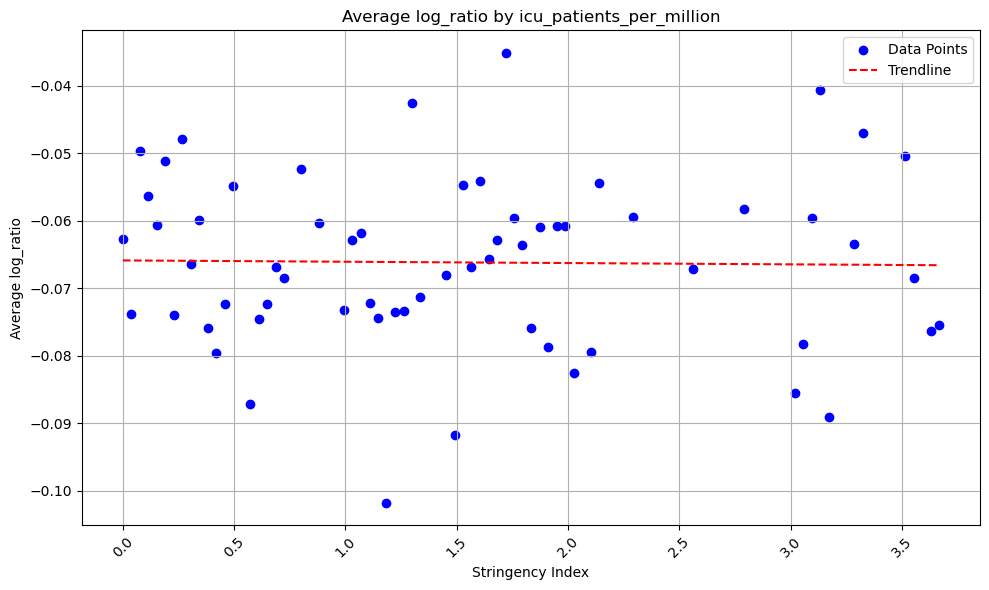

In [137]:
avg_log_ratio_by_stringency = filtered_dataset.groupby('icu_patients_per_million')['log_ratio'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(avg_log_ratio_by_stringency['icu_patients_per_million'], avg_log_ratio_by_stringency['log_ratio'], color='blue', label='Data Points')

z = np.polyfit(avg_log_ratio_by_stringency['icu_patients_per_million'], avg_log_ratio_by_stringency['log_ratio'], 1)
p = np.poly1d(z)
plt.plot(avg_log_ratio_by_stringency['icu_patients_per_million'], p(avg_log_ratio_by_stringency['icu_patients_per_million']), "r--", label='Trendline')

plt.title('Average log_ratio by icu_patients_per_million')
plt.xlabel('Stringency Index')
plt.ylabel('Average log_ratio')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()


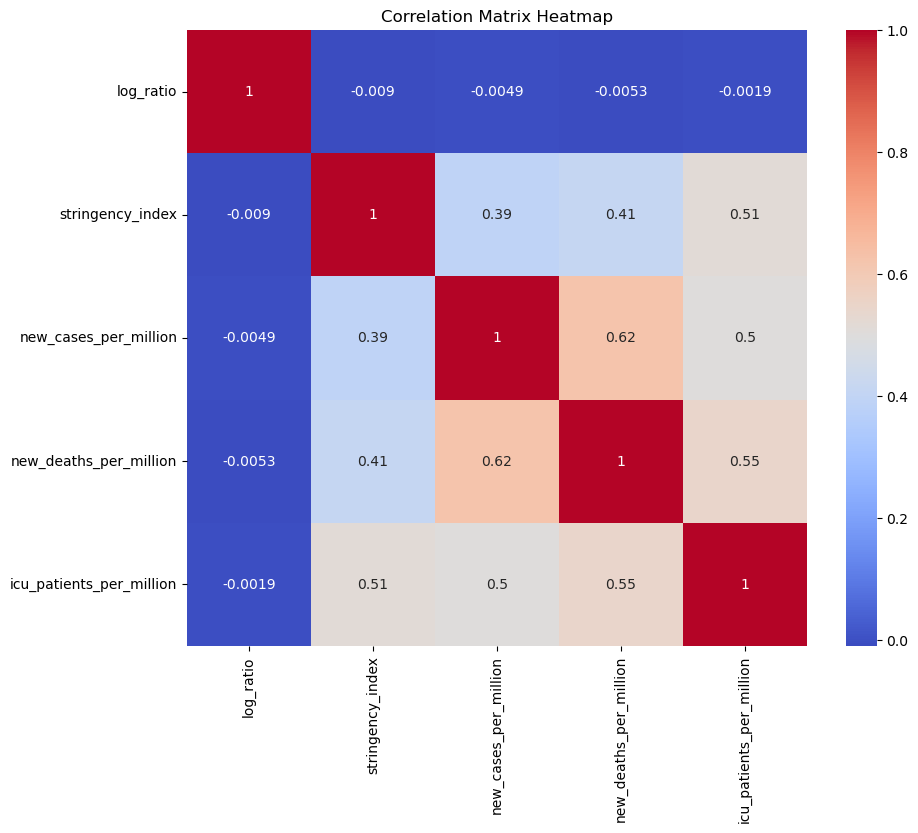

In [170]:

selected_columns = ['log_ratio', 'stringency_index', 'new_cases_per_million', 'new_deaths_per_million', 'icu_patients_per_million']
subset = filtered_dataset[selected_columns]

correlation_matrix = subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()


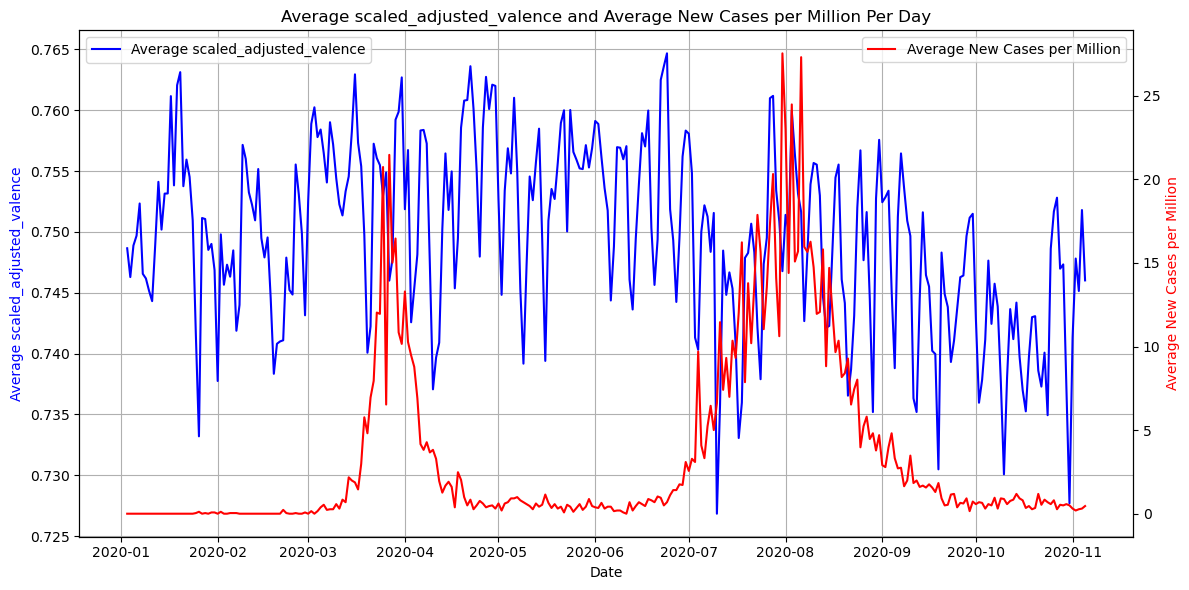

In [139]:

avg_scaled_adjusted_valence = filtered_dataset.groupby('date')['scaled_adjusted_valence'].mean().reset_index()
avg_new_cases = filtered_dataset.groupby('date')['new_cases_per_million'].mean().reset_index()

plt.figure(figsize=(12, 6))

plt.plot(avg_scaled_adjusted_valence['date'], avg_scaled_adjusted_valence['scaled_adjusted_valence'], color='blue', label='Average scaled_adjusted_valence')
plt.xlabel('Date')
plt.ylabel('Average scaled_adjusted_valence', color='blue')
plt.grid(True)
plt.legend(loc='upper left')

ax2 = plt.twinx()
ax2.plot(avg_new_cases['date'], avg_new_cases['new_cases_per_million'], color='red', label='Average New Cases per Million')
ax2.set_ylabel('Average New Cases per Million', color='red')
ax2.legend(loc='upper right')

plt.title('Average scaled_adjusted_valence and Average New Cases per Million Per Day')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


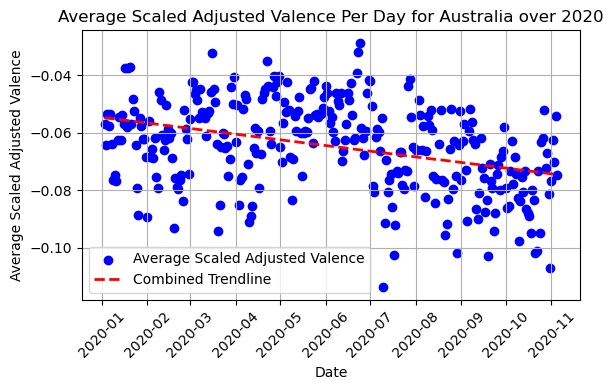

In [37]:
avg_scaled_adjusted_valence = filtered_dataset.groupby('date')['log_ratio'].mean().reset_index()

plt.figure(figsize=(6, 4))
plt.scatter(avg_scaled_adjusted_valence['date'], avg_scaled_adjusted_valence['log_ratio'], color='blue', label='Average Scaled Adjusted Valence')

def linear_fit(x, a, b):
    return a * x + b

x = np.arange(len(avg_scaled_adjusted_valence))
params, _ = curve_fit(linear_fit, x, avg_scaled_adjusted_valence['log_ratio'])
a, b = params
trendline = a * x + b
plt.plot(avg_scaled_adjusted_valence['date'], trendline, linestyle='--', linewidth=2, label='Combined Trendline', color='red')
plt.xlabel('Date')
plt.ylabel('Average Scaled Adjusted Valence')
plt.title('Average Scaled Adjusted Valence Per Day for Australia over 2020')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


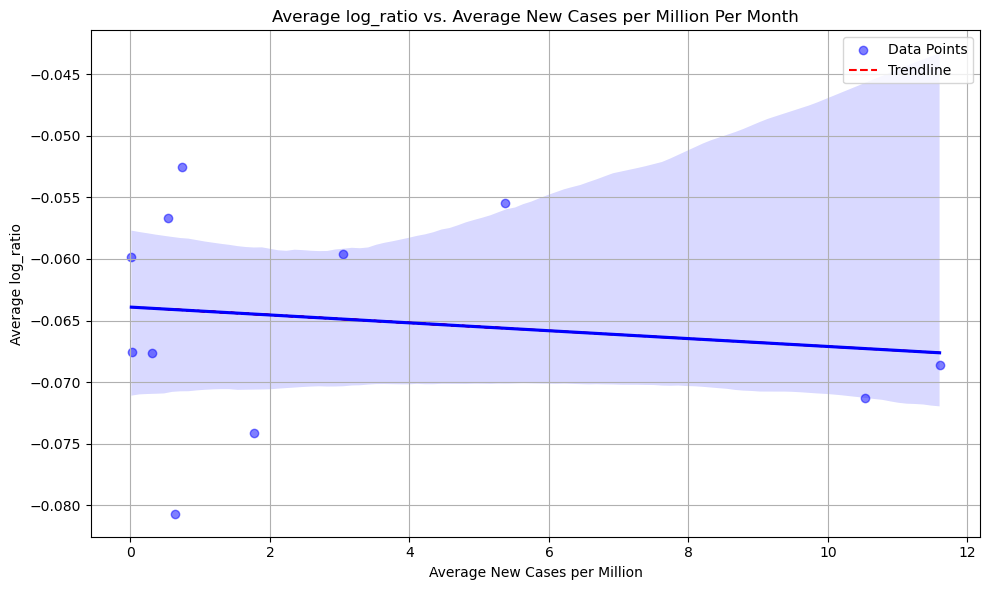

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(avg_new_cases['new_cases_per_million'], avg_log_ratio['log_ratio'], alpha=0.5, color='blue', label='Data Points')
z = np.polyfit(avg_new_cases['new_cases_per_million'], avg_log_ratio['log_ratio'], 1)
p = np.poly1d(z)
plt.plot(avg_new_cases['new_cases_per_million'], p(avg_new_cases['new_cases_per_million']), "r--", label='Trendline')
sns.regplot(x=avg_new_cases['new_cases_per_million'], y=avg_log_ratio['log_ratio'], ci=95, color='blue', scatter=False)

plt.title('Average log_ratio vs. Average New Cases per Million Per Month')
plt.xlabel('Average New Cases per Million')
plt.ylabel('Average log_ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


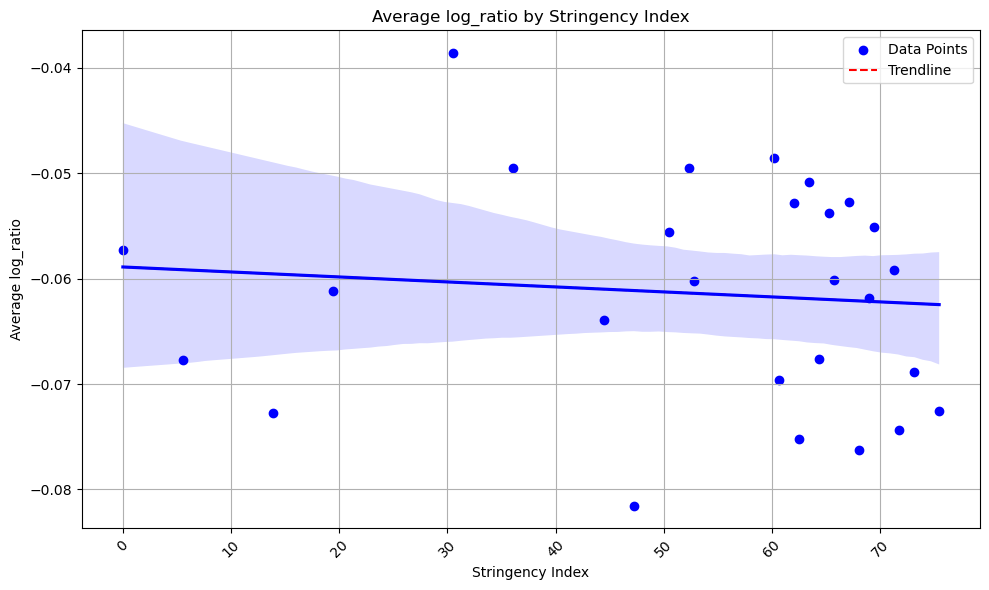

In [27]:
avg_log_ratio_by_stringency = filtered_dataset.groupby('stringency_index')['log_ratio'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(avg_log_ratio_by_stringency['stringency_index'], avg_log_ratio_by_stringency['log_ratio'], color='blue', label='Data Points')
z = np.polyfit(avg_log_ratio_by_stringency['stringency_index'], avg_log_ratio_by_stringency['log_ratio'], 1)
p = np.poly1d(z)
plt.plot(avg_log_ratio_by_stringency['stringency_index'], p(avg_log_ratio_by_stringency['stringency_index']), "r--", label='Trendline')
sns.regplot(x=avg_log_ratio_by_stringency['stringency_index'], y=avg_log_ratio_by_stringency['log_ratio'], ci=95, color='blue', scatter=False)
plt.title('Average log_ratio by Stringency Index')
plt.xlabel('Stringency Index')
plt.ylabel('Average log_ratio')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()